# Домашнее задание "Модели ARIMA"
## Задание
### Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук


### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip install arch

In [3]:
from arch import arch_model

In [4]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Импорт данных


In [5]:
# нестационарный ряд
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")

In [6]:
sales_of_company_x.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


### Вспомогательные функции

In [7]:
def test_stationarity(timeseries):
    '''Функция выдаёт результаты теста Дика-Фуллера(p-value, статистику, количество лагов, количество точек) на стационарность'''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    '''Функция выдаёт результаты теста Дика-Фуллера при помощи функции test_stationarity.
    Проверяет принадлежность объекта указнному классу(в данном случае pd.Series)
    Затем выводит 3 графика: временной ряд, автокорелляция, частитчная автокорелляция перед этим идёт настройка поля отображения'''
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [9]:
def _get_best_model(TS):
    '''Подбор гиперпараметров для модели ARIMA'''
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

### Решение

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\first\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


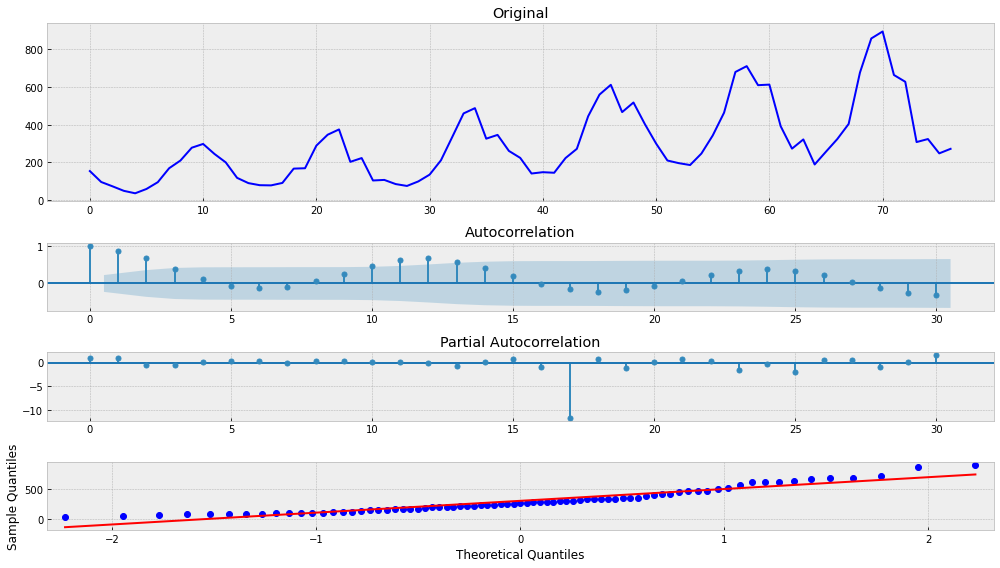

In [10]:
tsplot(sales_of_company_x.Count, lags = 30)

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [11]:
gr_1 = boxcox(sales_of_company_x.Count, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\first\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


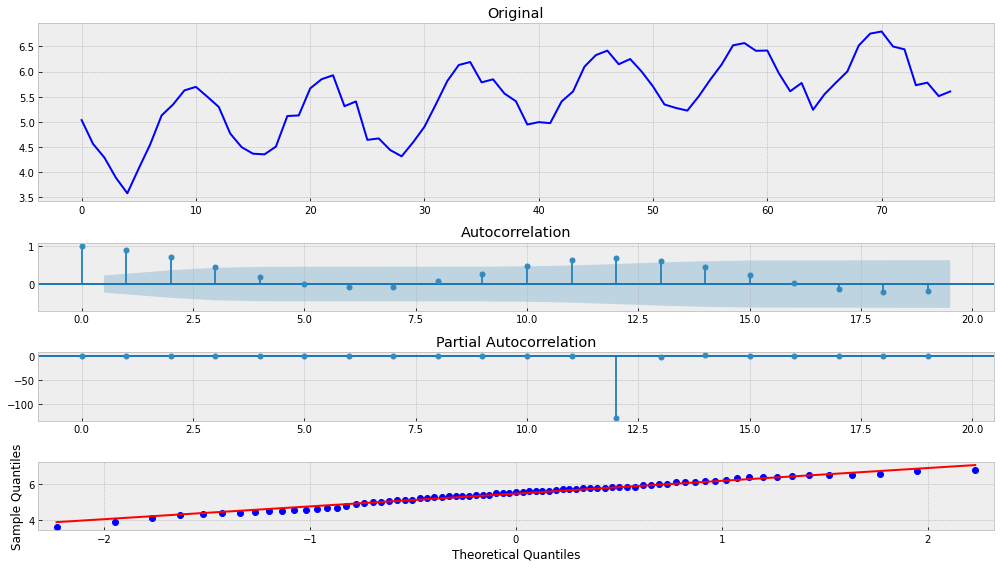

In [12]:
tsplot(gr_1)

Удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [13]:
gr_2 = np.diff(gr_1, 1)

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


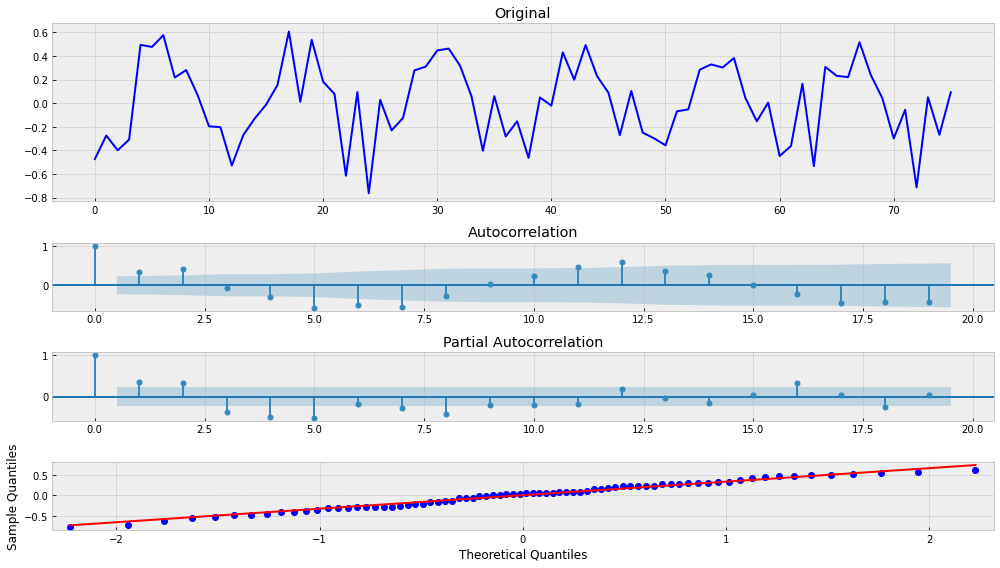

In [14]:
tsplot(gr_2)

## Модель GARCH

Подбор гиперпараметров для модели GARCH (p, d, q)

In [15]:
aic, order, mdl = _get_best_model(gr_2)

C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\first\anaconda3\lib\

aic: -33.21456 | order: (3, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                -9.171934e+00
p-value                        2.375466e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


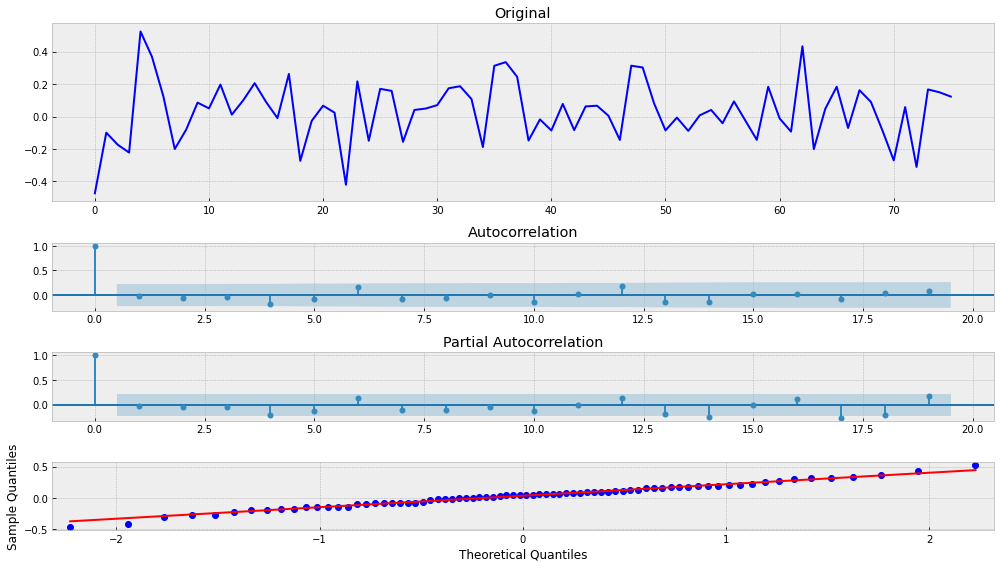

In [16]:
tsplot(mdl.resid)

In [27]:
order

(3, 0, 2)

In [28]:
# Будем обучать GARCH, используя лучшие гиперпараметры ARIMA
p_ = order[0]
o_ = order[1]
q_ = order[2]

In [19]:
# Лучшее обучение обычно при распределении Т Стьюдента
am = arch_model(gr_2, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -21.9251
Distribution:      Standardized Student's t   AIC:                           59.8501
Method:                  Maximum Likelihood   BIC:                           78.4960
                                              No. Observations:                   76
Date:                      Tue, Jan 18 2022   Df Residuals:                       75
Time:                              09:44:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [50]:
forecast = res.forecast(horizon=6, method='simulation')

In [51]:
res.forecast

<bound method ARCHModelFixedResult.forecast of                         Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -21.9251
Distribution:      Standardized Student's t   AIC:                           59.8501
Method:                  Maximum Likelihood   BIC:                           78.4960
                                              No. Observations:                   76
Date:                      Tue, Jan 18 2022   Df Residuals:                       75
Time:                              09:44:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------

In [52]:
forecast

In [53]:
pd.Series(gr_2).rolling(6).var()

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
71    0.078475
72    0.182395
73    0.113956
74    0.083771
75    0.089188
Length: 76, dtype: float64

In [54]:
# Прогноз условной дисперсии остатков.
forecast.residual_variance.tail(2)

,h.1,h.2,h.3,h.4,h.5,h.6
74,NaN,NaN,NaN,NaN,NaN,NaN
75,0.103003,0.083564,0.107158,0.105247,0.10965,0.107531


In [55]:
#Условная дисперсия прогноза
forecast.variance.tail(2)

,h.1,h.2,h.3,h.4,h.5,h.6
74,NaN,NaN,NaN,NaN,NaN,NaN
75,0.103003,0.083564,0.107158,0.105247,0.10965,0.107531


In [56]:
#Прогноз условное среднее.
forecast.mean.tail(2)

,h.1,h.2,h.3,h.4,h.5,h.6
74,NaN,NaN,NaN,NaN,NaN,NaN
75,0.020721,0.020721,0.020721,0.020721,0.020721,0.020721


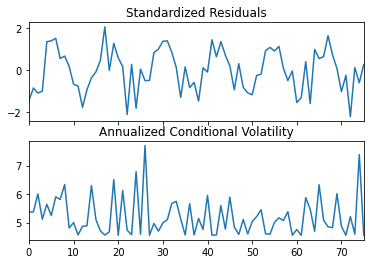

In [58]:
#быстрая визуализация стандартизованных остатков и условной волатильности.
fig = res.plot(annualize="D")

In [61]:
res.params

mu          2.072134e-02
omega       8.228195e-02
alpha[1]    9.379614e-11
alpha[2]    2.497592e-01
alpha[3]    1.078531e-10
beta[1]     2.385556e-12
beta[2]     1.465945e-11
nu          2.307369e+02
Name: params, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


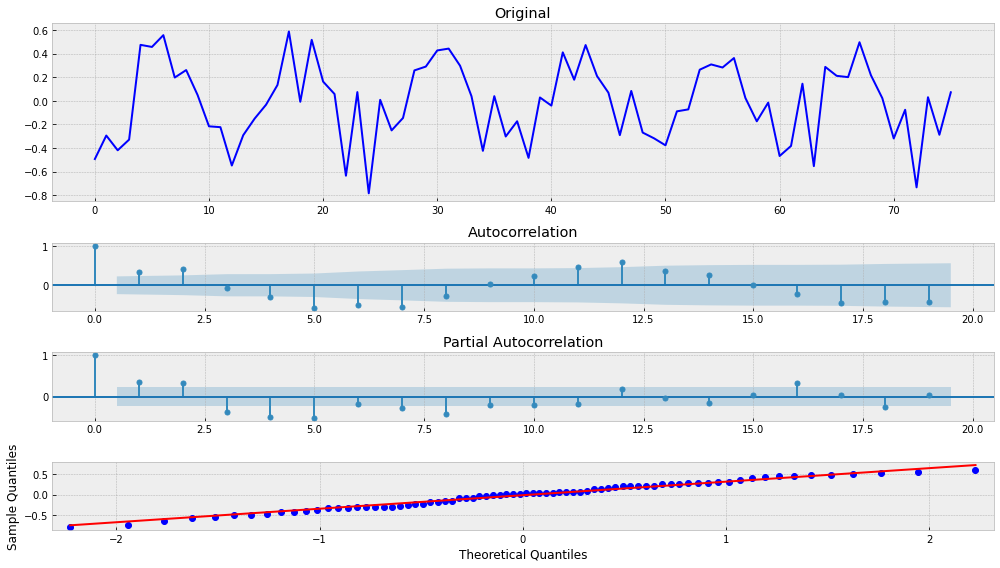

In [57]:
tsplot(res.resid)